In [1]:
import pandas as pd
import numpy as np
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
import shap
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")


In [4]:
# Load the dataset
file_path = "data/featured_clinvar_result.csv"
df = pd.read_csv(file_path)

# Define features (X) and target (y)
X = df.drop(columns=["label"])
y = df["label"]

# Drop non-numeric columns (like text columns accidentally left)
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Dropping non-numeric columns (if any): {non_numeric_cols}")
X = X.drop(columns=non_numeric_cols)

# Drop rows with any remaining NaNs
X = X.dropna()
y = y.loc[X.index]

# Reset index
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Check dataset info
print(f"✅ Dataset shape after cleaning: {X.shape}")
print(f"✅ Feature count: {X.shape[1]}")
print(f"✅ Class distribution:\n{y.value_counts()}")


Dropping non-numeric columns (if any): ['sequence_window_fixed']
✅ Dataset shape after cleaning: (1215, 37)
✅ Feature count: 37
✅ Class distribution:
label
0    632
1    583
Name: count, dtype: int64


In [5]:
# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train-Test Split Done: {X_train.shape[0]} Train Samples, {X_test.shape[0]} Test Samples")


Train-Test Split Done: 972 Train Samples, 243 Test Samples


In [6]:
# Apply SMOTE oversampling to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after oversampling
print("Original class distribution:")
print(pd.Series(y_train).value_counts())
print("\nResampled class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Original class distribution:
label
0    506
1    466
Name: count, dtype: int64

Resampled class distribution:
label
0    506
1    506
Name: count, dtype: int64


In [9]:
# Parameter optimization functions
def logistic_regression_params(trial):
    return {
        'C': trial.suggest_float('C', 0.01, 10, log=True),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'max_iter': 1000,
        'random_state': 42
    }

def knn_params(trial):
    return {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance'])
    }

def svm_params(trial):
    return {
        'C': trial.suggest_float('C', 0.01, 10, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'probability': True,
        'random_state': 42
    }

def decision_tree_params(trial):
    return {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'random_state': 42
    }

def random_forest_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'random_state': 42
    }

def xgboost_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42
    }

def adaboost_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'random_state': 42
    }

def catboost_params(trial):
    return {
        'iterations': trial.suggest_int('iterations', 50, 200),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': False
    }

def gradient_boost_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42
    }

In [10]:
def optimize_model(name, model_class, param_func, trials=30):
    """Optimize model hyperparameters using Optuna"""
    def objective(trial):
        params = param_func(trial)
        model = model_class(**params)
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        score = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy').mean()
        return score

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=trials)
    best_model = model_class(**study.best_params)
    return best_model, study

# Model definitions
model_defs = [
    ("Logistic Regression", LogisticRegression, logistic_regression_params),
    ("KNN", KNeighborsClassifier, knn_params),
    ("SVM", SVC, svm_params),
    ("Decision Tree", DecisionTreeClassifier, decision_tree_params),
    ("Random Forest", RandomForestClassifier, random_forest_params),
    ("XGBoost", XGBClassifier, xgboost_params),
    ("AdaBoost", AdaBoostClassifier, adaboost_params),
    ("CatBoost", CatBoostClassifier, catboost_params),
    ("Gradient Boosting", GradientBoostingClassifier, gradient_boost_params)
]


In [11]:
# Train and evaluate models
results = {}
model_pipelines = {}

print("\n" + "="*50)
print("TRAINING AND EVALUATION")
print("="*50)

for name, model_class, param_func in model_defs:
    print(f"\nTraining {name}...")

    start_time = time.time()
    
    # Optimize hyperparameters
    best_model, study = optimize_model(name, model_class, param_func)
    
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', best_model)
    ])
    
    # Train the model
    pipeline.fit(X_train_resampled, y_train_resampled)
    training_time = time.time() - start_time
    
    # Inference on test set
    start_inference = time.time()
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test) if hasattr(pipeline.named_steps['model'], 'predict_proba') else None
    inference_time = time.time() - start_inference

    # Train prediction for overfitting check
    y_train_pred = pipeline.predict(X_train_resampled)

    # Metrics
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    results[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time,
        'inference_time': inference_time,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'report': classification_report(y_test, y_pred),
        'confusion': confusion_matrix(y_test, y_pred),
        'best_params': study.best_params,
        'overfit_delta': round(train_accuracy - test_accuracy, 4)
    }
    
    model_pipelines[name] = pipeline
    
    # Print metrics
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy : {test_accuracy:.4f}")
    print(f"Overfit Δ     : {train_accuracy - test_accuracy:.4f}")
    print(f"Training Time : {training_time:.2f}s")
    print(f"Inference Time: {inference_time:.4f}s")


[I 2025-06-26 17:13:41,897] A new study created in memory with name: no-name-b470e25c-ff2b-47b3-99ad-18b068f10013



TRAINING AND EVALUATION

Training Logistic Regression...


[I 2025-06-26 17:13:42,273] Trial 0 finished with value: 0.9357947617421839 and parameters: {'C': 0.36685656339919415, 'solver': 'saga'}. Best is trial 0 with value: 0.9357947617421839.
[I 2025-06-26 17:13:42,356] Trial 1 finished with value: 0.9347997853972589 and parameters: {'C': 0.21877368081524007, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9357947617421839.
[I 2025-06-26 17:13:43,347] Trial 2 finished with value: 0.9338194410574063 and parameters: {'C': 3.6999225187558364, 'solver': 'saga'}. Best is trial 0 with value: 0.9357947617421839.
[I 2025-06-26 17:13:43,477] Trial 3 finished with value: 0.9357898844071599 and parameters: {'C': 0.0744899058767215, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9357947617421839.
[I 2025-06-26 17:13:43,990] Trial 4 finished with value: 0.9318441203726284 and parameters: {'C': 0.8455230395941414, 'solver': 'saga'}. Best is trial 0 with value: 0.9357947617421839.
[I 2025-06-26 17:13:44,046] Trial 5 finished with value: 0.9170

Train Accuracy: 0.9575
Test Accuracy : 0.9465
Overfit Δ     : 0.0110
Training Time : 6.08s
Inference Time: 0.0021s

Training KNN...


[I 2025-06-26 17:13:48,231] Trial 1 finished with value: 0.9189923425840121 and parameters: {'n_neighbors': 5, 'weights': 'uniform'}. Best is trial 1 with value: 0.9189923425840121.
[I 2025-06-26 17:13:48,300] Trial 2 finished with value: 0.9357801297371117 and parameters: {'n_neighbors': 13, 'weights': 'distance'}. Best is trial 2 with value: 0.9357801297371117.
[I 2025-06-26 17:13:48,359] Trial 3 finished with value: 0.9328049553723845 and parameters: {'n_neighbors': 7, 'weights': 'distance'}. Best is trial 2 with value: 0.9357801297371117.
[I 2025-06-26 17:13:48,421] Trial 4 finished with value: 0.9328049553723845 and parameters: {'n_neighbors': 9, 'weights': 'distance'}. Best is trial 2 with value: 0.9357801297371117.
[I 2025-06-26 17:13:48,539] Trial 5 finished with value: 0.9061551968004682 and parameters: {'n_neighbors': 14, 'weights': 'uniform'}. Best is trial 2 with value: 0.9357801297371117.
[I 2025-06-26 17:13:48,609] Trial 6 finished with value: 0.9387406720967663 and param

Train Accuracy: 1.0000
Test Accuracy : 0.9383
Overfit Δ     : 0.0617
Training Time : 2.58s
Inference Time: 0.0060s

Training SVM...


[I 2025-06-26 17:13:50,849] Trial 0 finished with value: 0.9229283519484953 and parameters: {'C': 0.5011677158697315, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.9229283519484953.
[I 2025-06-26 17:13:51,332] Trial 1 finished with value: 0.9427059454713944 and parameters: {'C': 0.23171831995989473, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.9427059454713944.
[I 2025-06-26 17:13:51,665] Trial 2 finished with value: 0.950582841535385 and parameters: {'C': 5.6477656579547535, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.950582841535385.
[I 2025-06-26 17:13:52,129] Trial 3 finished with value: 0.9278642149929279 and parameters: {'C': 3.590674746436869, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 2 with value: 0.950582841535385.
[I 2025-06-26 17:13:52,475] Trial 4 finished with value: 0.9495927425254841 and parameters: {'C': 5.095244642247742, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 2 with value: 0.950582841

Train Accuracy: 0.9842
Test Accuracy : 0.9424
Overfit Δ     : 0.0418
Training Time : 12.66s
Inference Time: 0.0062s

Training Decision Tree...


[I 2025-06-26 17:14:03,498] Trial 2 finished with value: 0.8794420328732381 and parameters: {'max_depth': 4, 'min_samples_split': 2}. Best is trial 0 with value: 0.9545237282348925.
[I 2025-06-26 17:14:03,569] Trial 3 finished with value: 0.9515631858752378 and parameters: {'max_depth': 11, 'min_samples_split': 3}. Best is trial 0 with value: 0.9545237282348925.
[I 2025-06-26 17:14:03,639] Trial 4 finished with value: 0.9485880115105108 and parameters: {'max_depth': 17, 'min_samples_split': 8}. Best is trial 0 with value: 0.9545237282348925.
[I 2025-06-26 17:14:03,698] Trial 5 finished with value: 0.8794420328732381 and parameters: {'max_depth': 4, 'min_samples_split': 4}. Best is trial 0 with value: 0.9545237282348925.
[I 2025-06-26 17:14:03,765] Trial 6 finished with value: 0.9495781105204116 and parameters: {'max_depth': 20, 'min_samples_split': 9}. Best is trial 0 with value: 0.9545237282348925.
[I 2025-06-26 17:14:03,831] Trial 7 finished with value: 0.9485880115105108 and paramet

Train Accuracy: 0.9852
Test Accuracy : 0.9712
Overfit Δ     : 0.0140
Training Time : 2.29s
Inference Time: 0.0020s

Training Random Forest...


[I 2025-06-26 17:14:06,465] Trial 0 finished with value: 0.917007267229186 and parameters: {'n_estimators': 128, 'max_depth': 4}. Best is trial 0 with value: 0.917007267229186.
[I 2025-06-26 17:14:07,557] Trial 1 finished with value: 0.9644295956689266 and parameters: {'n_estimators': 138, 'max_depth': 10}. Best is trial 1 with value: 0.9644295956689266.
[I 2025-06-26 17:14:08,957] Trial 2 finished with value: 0.9555235819148418 and parameters: {'n_estimators': 182, 'max_depth': 7}. Best is trial 1 with value: 0.9644295956689266.
[I 2025-06-26 17:14:09,981] Trial 3 finished with value: 0.9585085109496172 and parameters: {'n_estimators': 128, 'max_depth': 8}. Best is trial 1 with value: 0.9644295956689266.
[I 2025-06-26 17:14:10,569] Trial 4 finished with value: 0.9654148173438033 and parameters: {'n_estimators': 58, 'max_depth': 12}. Best is trial 4 with value: 0.9654148173438033.
[I 2025-06-26 17:14:11,049] Trial 5 finished with value: 0.9654099400087791 and parameters: {'n_estimators

Train Accuracy: 0.9990
Test Accuracy : 0.9835
Overfit Δ     : 0.0155
Training Time : 28.31s
Inference Time: 0.0090s

Training XGBoost...


[I 2025-06-26 17:14:34,525] Trial 0 finished with value: 0.9663805296785835 and parameters: {'n_estimators': 156, 'learning_rate': 0.19414300417097935, 'max_depth': 6}. Best is trial 0 with value: 0.9663805296785835.
[I 2025-06-26 17:14:34,957] Trial 1 finished with value: 0.9653904306686826 and parameters: {'n_estimators': 132, 'learning_rate': 0.2946802650419181, 'max_depth': 9}. Best is trial 0 with value: 0.9663805296785835.
[I 2025-06-26 17:14:35,394] Trial 2 finished with value: 0.9634151099839048 and parameters: {'n_estimators': 130, 'learning_rate': 0.25571796579823036, 'max_depth': 9}. Best is trial 0 with value: 0.9663805296785835.
[I 2025-06-26 17:14:35,914] Trial 3 finished with value: 0.9663854070136079 and parameters: {'n_estimators': 158, 'learning_rate': 0.1548896419759464, 'max_depth': 8}. Best is trial 3 with value: 0.9663854070136079.
[I 2025-06-26 17:14:36,268] Trial 4 finished with value: 0.9683656050334097 and parameters: {'n_estimators': 89, 'learning_rate': 0.27

Train Accuracy: 1.0000
Test Accuracy : 0.9835
Overfit Δ     : 0.0165
Training Time : 11.50s
Inference Time: 0.0070s

Training AdaBoost...


[I 2025-06-26 17:14:46,854] Trial 0 finished with value: 0.9535385065600156 and parameters: {'n_estimators': 123, 'learning_rate': 0.6107907589456759}. Best is trial 0 with value: 0.9535385065600156.
[I 2025-06-26 17:14:48,460] Trial 1 finished with value: 0.952563039555187 and parameters: {'n_estimators': 139, 'learning_rate': 0.9393990144652443}. Best is trial 0 with value: 0.9535385065600156.
[I 2025-06-26 17:14:49,276] Trial 2 finished with value: 0.9288396819977564 and parameters: {'n_estimators': 71, 'learning_rate': 0.10582374550532428}. Best is trial 0 with value: 0.9535385065600156.
[I 2025-06-26 17:14:50,976] Trial 3 finished with value: 0.9574891479295712 and parameters: {'n_estimators': 154, 'learning_rate': 0.3978878515597493}. Best is trial 3 with value: 0.9574891479295712.
[I 2025-06-26 17:14:52,343] Trial 4 finished with value: 0.9555138272447934 and parameters: {'n_estimators': 122, 'learning_rate': 0.6886207449292925}. Best is trial 3 with value: 0.9574891479295712.
[

Train Accuracy: 0.9822
Test Accuracy : 0.9671
Overfit Δ     : 0.0151
Training Time : 32.75s
Inference Time: 0.0150s

Training CatBoost...


[I 2025-06-26 17:15:20,182] Trial 0 finished with value: 0.9614300346290786 and parameters: {'iterations': 127, 'depth': 5, 'learning_rate': 0.14017308826011207, 'l2_leaf_reg': 7.942670923630757}. Best is trial 0 with value: 0.9614300346290786.
[I 2025-06-26 17:15:25,510] Trial 1 finished with value: 0.9584743696044482 and parameters: {'iterations': 89, 'depth': 9, 'learning_rate': 0.06837628001825936, 'l2_leaf_reg': 3.411706809810283}. Best is trial 0 with value: 0.9614300346290786.
[I 2025-06-26 17:15:51,783] Trial 2 finished with value: 0.9614397892991271 and parameters: {'iterations': 199, 'depth': 10, 'learning_rate': 0.09663190914468703, 'l2_leaf_reg': 1.248683498310218}. Best is trial 2 with value: 0.9614397892991271.
[I 2025-06-26 17:16:19,757] Trial 3 finished with value: 0.9575037799346438 and parameters: {'iterations': 195, 'depth': 10, 'learning_rate': 0.2804322769570494, 'l2_leaf_reg': 3.6309500221773408}. Best is trial 2 with value: 0.9614397892991271.
[I 2025-06-26 17:16

0:	learn: 0.5424332	total: 30.6ms	remaining: 3.33s
1:	learn: 0.4472685	total: 54.9ms	remaining: 2.97s
2:	learn: 0.3645182	total: 75.9ms	remaining: 2.71s
3:	learn: 0.3030396	total: 96.8ms	remaining: 2.56s
4:	learn: 0.2522908	total: 119ms	remaining: 2.5s
5:	learn: 0.2089124	total: 139ms	remaining: 2.42s
6:	learn: 0.1770268	total: 161ms	remaining: 2.37s
7:	learn: 0.1610559	total: 181ms	remaining: 2.31s
8:	learn: 0.1426552	total: 202ms	remaining: 2.27s
9:	learn: 0.1335665	total: 222ms	remaining: 2.21s
10:	learn: 0.1278663	total: 244ms	remaining: 2.19s
11:	learn: 0.1231782	total: 272ms	remaining: 2.22s
12:	learn: 0.1182608	total: 299ms	remaining: 2.23s
13:	learn: 0.1122900	total: 321ms	remaining: 2.2s
14:	learn: 0.1065509	total: 342ms	remaining: 2.17s
15:	learn: 0.1015227	total: 363ms	remaining: 2.13s
16:	learn: 0.0942773	total: 383ms	remaining: 2.1s
17:	learn: 0.0918700	total: 405ms	remaining: 2.07s
18:	learn: 0.0875251	total: 426ms	remaining: 2.04s
19:	learn: 0.0839263	total: 448ms	remain

[I 2025-06-26 17:33:34,168] A new study created in memory with name: no-name-e0c53038-cc0d-490a-9629-4be0ed092ec8


Train Accuracy: 1.0000
Test Accuracy : 0.9794
Overfit Δ     : 0.0206
Training Time : 1095.88s
Inference Time: 0.0109s

Training Gradient Boosting...


[I 2025-06-26 17:33:38,218] Trial 0 finished with value: 0.9594693459493733 and parameters: {'n_estimators': 76, 'learning_rate': 0.24576437234757675, 'max_depth': 7}. Best is trial 0 with value: 0.9594693459493733.
[I 2025-06-26 17:33:43,371] Trial 1 finished with value: 0.9525288982100181 and parameters: {'n_estimators': 91, 'learning_rate': 0.16976872899794943, 'max_depth': 10}. Best is trial 0 with value: 0.9594693459493733.
[I 2025-06-26 17:33:51,160] Trial 2 finished with value: 0.9604448129542018 and parameters: {'n_estimators': 125, 'learning_rate': 0.17169793413393386, 'max_depth': 9}. Best is trial 2 with value: 0.9604448129542018.
[I 2025-06-26 17:34:00,479] Trial 3 finished with value: 0.9545188508998683 and parameters: {'n_estimators': 170, 'learning_rate': 0.1039753592372044, 'max_depth': 9}. Best is trial 2 with value: 0.9604448129542018.
[I 2025-06-26 17:34:09,060] Trial 4 finished with value: 0.9564795395795738 and parameters: {'n_estimators': 138, 'learning_rate': 0.2

Train Accuracy: 1.0000
Test Accuracy : 0.9794
Overfit Δ     : 0.0206
Training Time : 161.29s
Inference Time: 0.0040s


In [12]:
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

# Create comparison dataframe
comparison_data = []
for name in results.keys():
    comparison_data.append({
        'Model': name,
        'Train Accuracy': results[name]['train_accuracy'],
        'Test Accuracy': results[name]['test_accuracy'],
        'Overfit Δ': results[name]['overfit_delta'],
        'Precision': results[name]['precision'],
        'Recall': results[name]['recall'],
        'F1-Score': results[name]['f1_score'],
        'Training Time (s)': results[name]['training_time'],
        'Inference Time (s)': results[name]['inference_time']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print(comparison_df.round(4))

# Save to CSV
comparison_df.to_csv("model_comparison.csv", index=False)
print(f"\nModel comparison saved to: results/model_comparison.csv")



MODEL COMPARISON
                 Model  Train Accuracy  Test Accuracy  Overfit Δ  Precision  \
0        Random Forest          0.9990         0.9835     0.0155     0.9837   
1              XGBoost          1.0000         0.9835     0.0165     0.9837   
2             CatBoost          1.0000         0.9794     0.0206     0.9797   
3    Gradient Boosting          1.0000         0.9794     0.0206     0.9797   
4        Decision Tree          0.9852         0.9712     0.0140     0.9715   
5             AdaBoost          0.9822         0.9671     0.0151     0.9672   
6  Logistic Regression          0.9575         0.9465     0.0110     0.9465   
7                  SVM          0.9842         0.9424     0.0418     0.9436   
8                  KNN          1.0000         0.9383     0.0617     0.9399   

   Recall  F1-Score  Training Time (s)  Inference Time (s)  
0  0.9835    0.9835            28.3053              0.0090  
1  0.9835    0.9835            11.4968              0.0070  
2  0.979

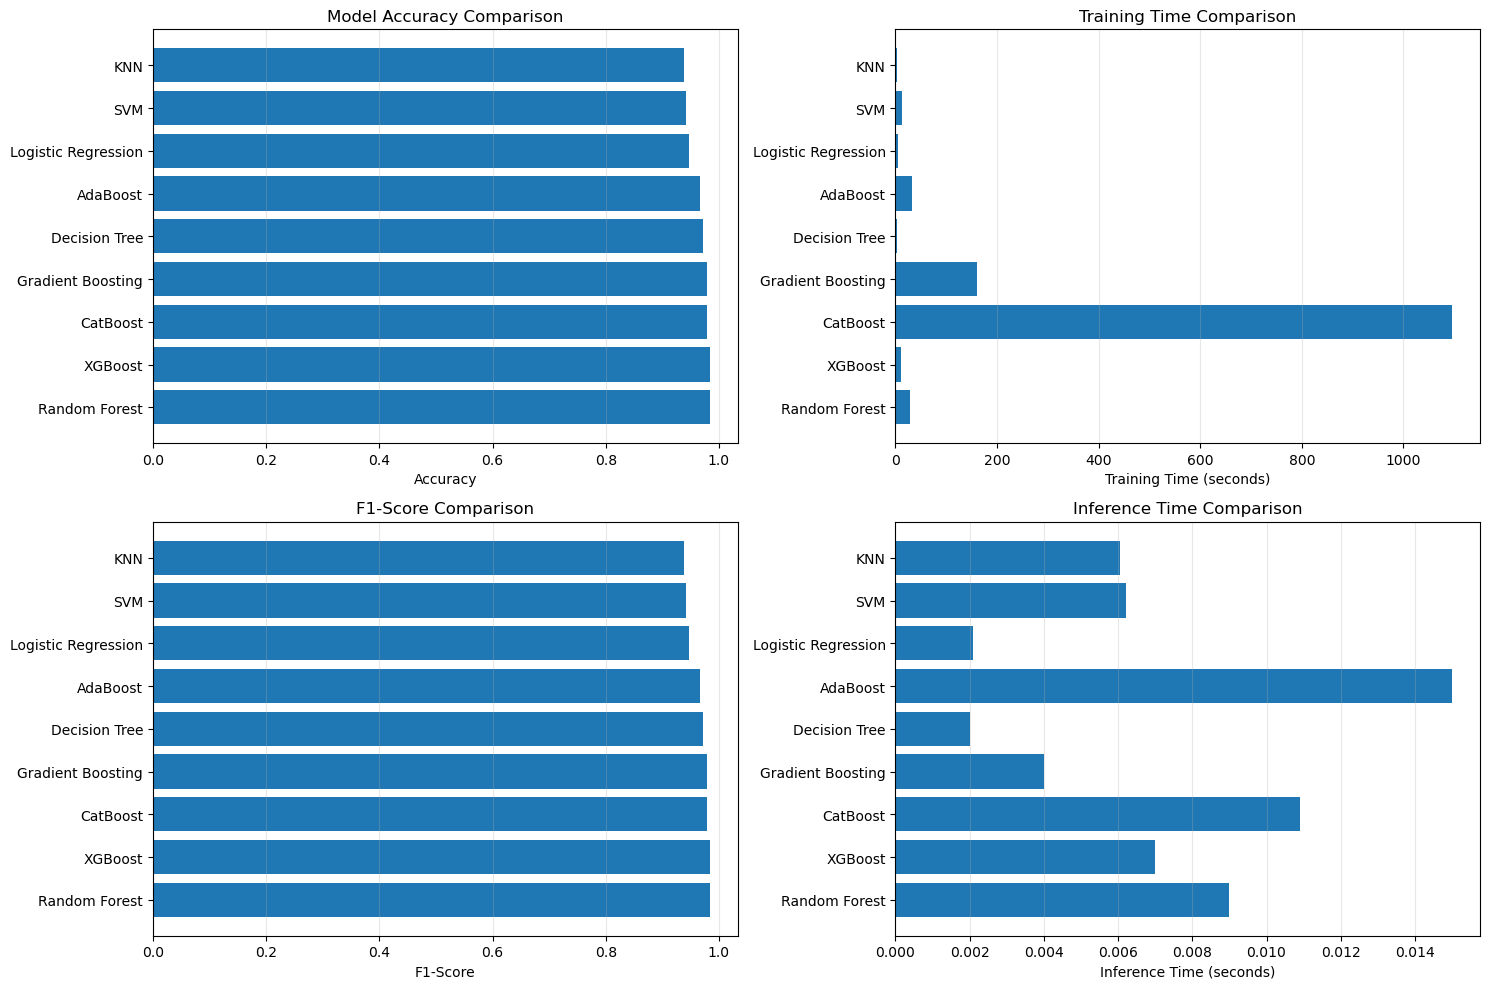

In [13]:
# Create performance visualization
plt.figure(figsize=(15, 10))

# Accuracy comparison
plt.subplot(2, 2, 1)
plt.barh(comparison_df['Model'], comparison_df['Test Accuracy'])
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='x', alpha=0.3)

# Training time comparison
plt.subplot(2, 2, 2)
plt.barh(comparison_df['Model'], comparison_df['Training Time (s)'])
plt.xlabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.grid(axis='x', alpha=0.3)

# F1-Score comparison
plt.subplot(2, 2, 3)
plt.barh(comparison_df['Model'], comparison_df['F1-Score'])
plt.xlabel('F1-Score')
plt.title('F1-Score Comparison')
plt.grid(axis='x', alpha=0.3)

# Inference time comparison
plt.subplot(2, 2, 4)
plt.barh(comparison_df['Model'], comparison_df['Inference Time (s)'])
plt.xlabel('Inference Time (seconds)')
plt.title('Inference Time Comparison')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [31]:
best_model_name = max(results, key=lambda k: results[k]['test_accuracy'])
best_pipeline = model_pipelines[best_model_name]

joblib.dump(best_pipeline, f"models/best_model_{best_model_name.replace(' ', '_').lower()}.pkl")
print(f"\n✅ Best model saved: {best_model_name}")


✅ Best model saved: Random Forest
